In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.7.0'

# 케라스의 순환 층 : LSTM과 GRU 

#### SimpleRNN 단점
- 실전에 사용하기에 너무 단순
- 이론적으로 시간 t에서 이전의 모든 타임스텝의 정보를 유지할 수 있으나, 실제로 긴 시간에 걸친 의존성은 학습할 수 없는 문제 발생
  - 그래디언트 소실 문제(vanishing)
  - 피드포워드 네트워크에 층을 많이 추가할수록 훈련하기 어려운 것과 같음

SimpleRNN 구조

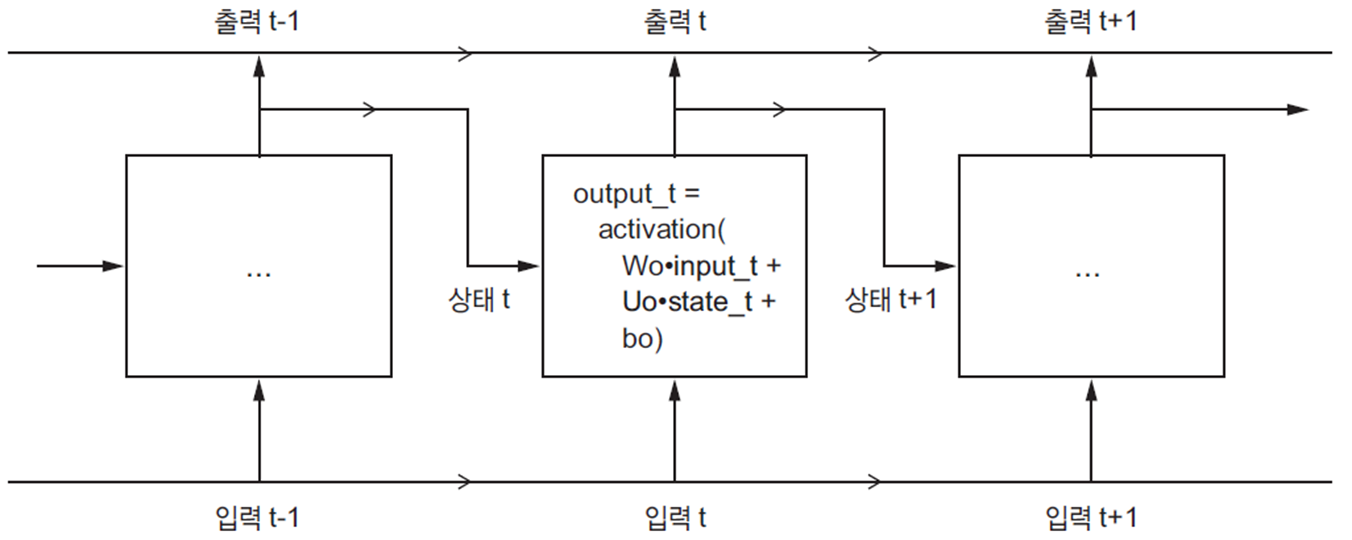

## LSTM, GRU 셀
- 그래디언트 소실 문제를 해결하기 위해 고안된 순환 층
- 1990년대 초 Hochreiter, Schmidhuber, Bengio

### LSTM(Long-Short-Term Memory) 알고리즘
- 1997, Hochreiter & Schmidhuber 개발
- SimpleRNN의 변종으로 정보를 여러 타임스텝에 걸쳐 나르는 방법이 추가됨
- 시퀀스 어느 지점에서 추출된 정보를 필요한 시점의 타입스텝에 줄 수 있도록 정보를 저장하여 오래된 시그널이 점차 소실되는 것을 막아줌

### LSTM 셀

: 긴 데이터를 효과적으로 학습하기 위해 고안된 순환층 

- 입력 게이트, 삭제 게이트, 출력 게이트 역할을 하는 작은 셀이 포함되어 있음
- 은닉 상태 이외의 셀 상태를 출력
- 셀 상태는 다음 층으로 전달되지 않으며 현재 셀에서만 순환됨

[그림] SimpleRNN에서 LSTM으로: 이동 트랙 추가

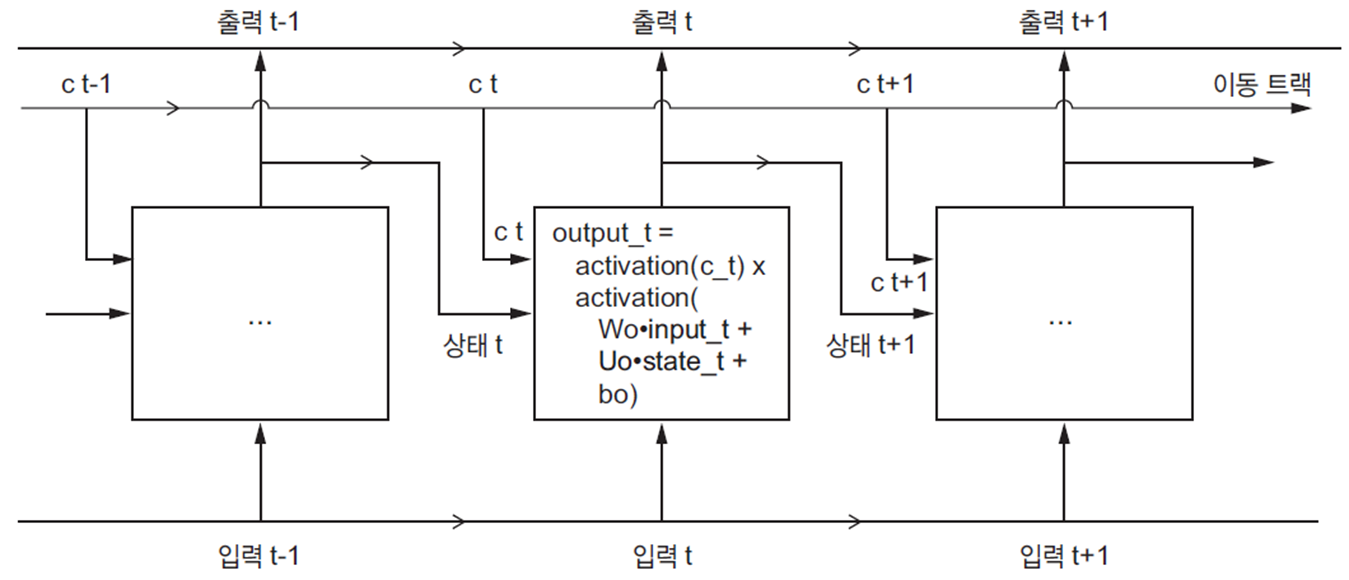

- c_t : 타임스텝 t에서의 이동 상태, c는 이동(carry)를 의미함
- c_t를 이용하여 셀이 변경됨
  - 입력 연결과 순환 연결(상태)로부터 이동상태(c_t) 정보가 합성된 후 다음 타입스텝으로 전달될 상태를 변경시킴

- 다음 이동 상태(c_t+1)는 3개의 SimpleRNN과 같은 변환이 관련되어 계산됨
  - y = activation(dot(state_t, U) + dot(input_t, W) + b)
  - 3개의 변환 모두 자신만의 가중치 행렬을 가짐

#### LSTM구조 : 출력(k), 입력(i), 삭제(f) 게이트라는 3개의 게이트가 존재

In [ ]:
# LSTM 구조의 의사코드(pseudocode)
'''
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
'''
# 새로운 이동상태(c_t+1) 계산
'''
c_t+1 = i_t * k_t + c_t * f_t
'''

- output_t에 적용되는 활성화 함수는 순서대로 tanh, sigmoid 함수임
- i_t, f_t에는 sigmoid 활성화함수가 적용되고, k_t에는 tanh 활성화 함수가 적용됨

[그림] LSTM 구조

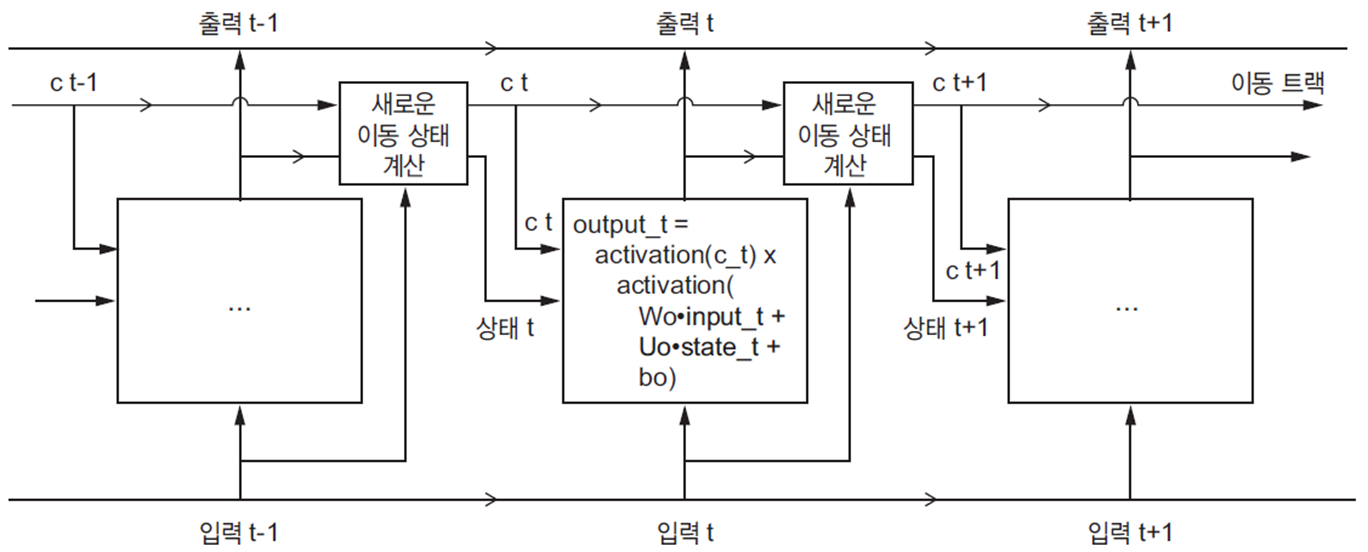

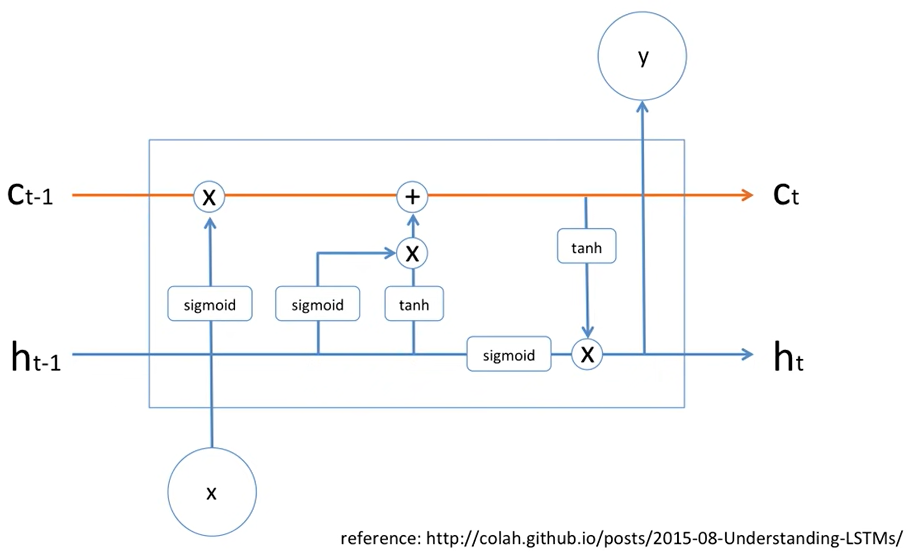

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

#### 텐서플로의 LSTM : LSTM 셀을 사용한 순환층 클래스
- 첫번째 매개변수 : 뉴런의 개수
- dropout : 입력에 대한 드롭아웃 비율 지정
- return_sequences : 모든 타임스텝의 은닉 상태를 출력할 지 결정. 기본값은 False 

## IMDB 분류를 위한 RNN 모델 : LSTM 층 사용

#### imdb 데이터 로딩 및 데이터 전처리

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

# 패딩
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

#### 모델 정의 : LSTM 셀

In [3]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


#### 모델 컴파일 및 훈련

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['acc'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

2022-03-25 11:49:19.149278: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6921 - acc: 0.5335 - val_loss: 0.6905 - val_acc: 0.5804
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6854 - acc: 0.6423 - val_loss: 0.6769 - val_acc: 0.6958
Epoch 3/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6286 - acc: 0.7212 - val_loss: 0.5815 - val_acc: 0.7178
Epoch 4/100
313/313 [==============================] - 5s 14ms/step - loss: 0.5661 - acc: 0.7285 - val_loss: 0.5542 - val_acc: 0.7414
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5405 - acc: 0.7487 - val_loss: 0.5356 - val_acc: 0.7476
Epoch 6/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5201 - acc: 0.7641 - val_loss: 0.5168 - val_acc: 0.7620
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5034 - acc: 0.7738 - val_loss: 0.5025 - val_acc: 0.7690
Epoch 8/100
313/313 [==============================] - 4s 14ms

#### 모델의 성능 시각화 : 정확도와 손실

In [6]:
import matplotlib.pyplot as plt

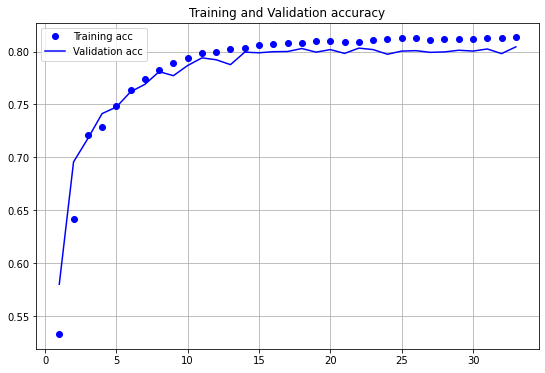

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(9,6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.grid()
plt.legend()
plt.show()

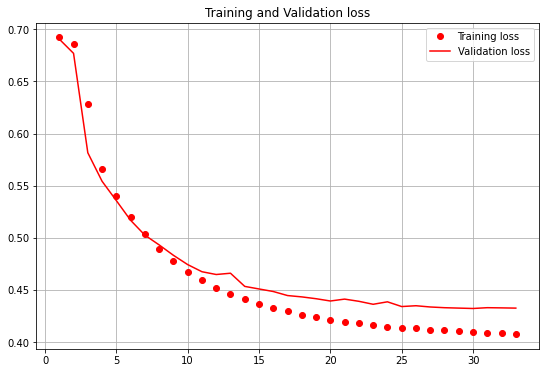

In [8]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(9,6))
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid()
plt.legend()
plt.show()

### 순환 층에 드롭아웃 적용하기

#### 모델 생성

In [9]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

#### 모델 컴파일 & 훈련

In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6926 - accuracy: 0.5313 - val_loss: 0.6920 - val_accuracy: 0.5688
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6912 - accuracy: 0.5739 - val_loss: 0.6904 - val_accuracy: 0.5902
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6888 - accuracy: 0.5974 - val_loss: 0.6874 - val_accuracy: 0.6130
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6844 - accuracy: 0.6186 - val_loss: 0.6816 - val_accuracy: 0.6308
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6754 - accuracy: 0.6470 - val_loss: 0.6696 - val_accuracy: 0.6528
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6506 - accuracy: 0.6724 - val_loss: 0.6227 - val_accuracy: 0.6998
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5896 - accuracy: 0.7204 - val_loss: 0.5740 - val_accuracy:

#### 모델 성능 시각화

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층을 연결하기

#### 모델 생성

In [ ]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

#### 모델 컴파일 & 훈련

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['acc'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

#### 모델 성능 시각화

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(9,6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(9,6))
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid()
plt.legend()
plt.show()

#### 모델 평가

In [ ]:
test_seq = pad_sequences(test_input, maxlen=100)

lstm_model = keras.models.load_model('model/best-lstm-model.h5')

lstm_model.evaluate(test_seq, test_target)

---

## GRU 셀

- 업데이트 게이트와 리셋 게이트 두 가지 게이트만이 존재
- LSTM의 간소화 버전이나 LSTM 셀 수준의 성능
    - GRU는 LSTM보다 학습 속도가 빠르다고 알려져있지만 여러 평가에서 GRU는 LSTM과 비슷한 성능을 보임

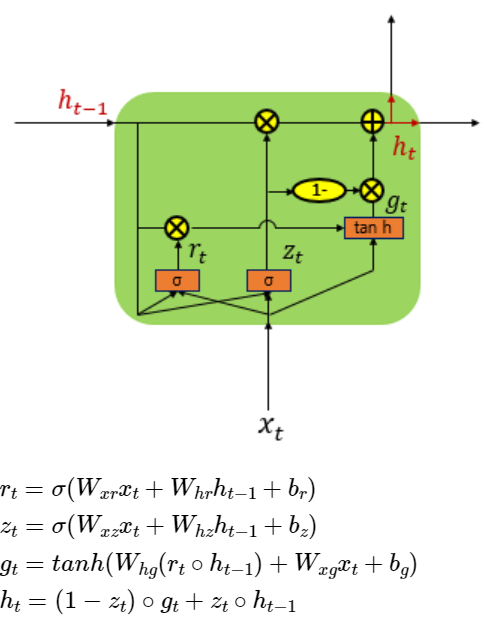

#### 텐서플로의 GRU : GRU 셀을 사용한 순환층 클래스

- 첫번째 매개변수 : 뉴런의 개수
- dropout : 입력에 대한 드롭아웃 비율 지정
- return_sequences : 모든 타임스텝의 은닉 상태를 출력할 지 결정. 기본값은 False 

## IMDB 분류를 위한 RNN 모델 : GRU셀 사용

### 1) 모델 생성

In [ ]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

### 2) 모델 컴파일 및 훈련

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('model/best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

### 3) 모델 성능 시각화

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['train', 'val'])
plt.show()

### 4) 저장된 모델을 로드하여 테스트 데이터에 적용

In [ ]:
test_seq = pad_sequences(test_input, maxlen=100)

gru_model = keras.models.load_model('model/best-gru-model.h5')

gru_model.evaluate(test_seq, test_target)